Importing libraries for calculation, plotting and colours

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

This next cell contains the most general functions which were used in
every question of this assignment. Most dont have in depth descriptions
since they are either simple or require a lot of index chasing.

In [142]:
# This function is used to iterate through all our arrays. Although it
# is generalised to n dimensions we only ever use it for 1 dimension
# since our function only depends on one space variable x.

def array_iter(array, function, indexes=[-2], dim=0, funcpars=[]):
    """Iterates through every entry in an n dimensional array 
    while keeping track of the index and runs the given function 
    'function' on each entry."""
    
    if indexes == [-2]:
        indexes = [-1, ]*array.ndim
        
    shape = array.shape    
    for i in range(shape[dim]):
        indexes[dim] += 1
        if dim != array.ndim-1:
            array_iter(array, function, indexes, dim+1, funcpars)
        else:
            function(array, indexes, *funcpars)
            
    indexes[dim] = -1
    return

# The boundary check function is used every time a derivative is calculated
def boundary_check(index, shape):
    """Checks if the index is on the boundary of an array, given the
    shape of the array. Returns true if it is."""
    
    # Checks if the index is at the start of any the dimension
    if 0 in index:
        return True
    else:
        for i in range(len(index)):
            # Checks if the index is at the end of any dimension
            if index[i] == shape[i]-1:
                return True
    return False


# Used to fill the derivative arrays (value of the pde) in every question 
def fill_deriv(array, index, t, deriv_func):
    """Calculates the derivative at every point in an array
    using the given function deriv_func and saves the value 
    into the global variable deriv_arr"""
    
    # Checking the boundary so we can tell the 
    # derivative function whether to implement
    # boundary condtitions or not
    if not boundary_check(index, array.shape):
    
        # Obtain the value of the differential
        diff = deriv_func(array, index, False)
        
        # Save the value at time t in deriv_arr
        deriv_arr[tuple([t] + index)] = diff
        
    else:
        diff = deriv_func(array, index, True)
        deriv_arr[tuple([t] + index)] = diff
    return

# This function was used to produce the plots in every question
def plot_data(x_end, t_end, sol_arr, dx, dt, format1 = [], 
              format2 = [], format3 = [], cm1='jet', cm2=cm.coolwarm):
    """Generates three plots, a heat map of the sol_arr, 
    a plot of the initial conditions and a 3-d plot of 
    the solution. The titles and axis names of each plot 
    can be passed via the format arguements"""
    
    if format1 == []:
        format1 = ['Heatmap of solution', 'X', 't']
    if format2 == []:
        format2 = ["Initial Condition Plot", 'X', 't'] 
    if format3 == []:
        format3 = ["3D plot of the solution", 'X', 't','U(x, t)']

    y, x = np.mgrid[slice(0, t_end, dt),
                    slice(0, x_end, dx)]
    z = sol_arr
    # Making the solution array fit in the grid
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()

    plt.figure(figsize = (10, 10))
    plt.subplot(2, 2, 1)
    plt.pcolormesh(x, y, z, cmap=cm1, vmin=z_min, vmax=z_max)
    plt.colorbar()

    plt.title(format1[0])
    plt.xlabel(format1[1])
    plt.ylabel(format1[2])
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.subplot(2, 2, 2)
    plt.plot(range(x_points), sol_arr[0])

    plt.title(format2[0])
    plt.xlabel(format2[1])
    plt.ylabel(format2[2])
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, y, z, cmap=cm2,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.title(format3[0])
    ax.set_xlabel(format3[1])
    ax.set_ylabel(format3[2])
    ax.set_zlabel(format3[3])


    plt.show()
    return

This next set of functions are specific to q1. Again most
are generalised to work for n space dimensions by relying on the
index provided by the arr_iter function

In [143]:
# Follows the formula given in the notes for the centered difference and then
# generalised to n dimensions

def cd2(array, index, boundary):
    """Finds the second derivative w.r.t. position using centered differences"""
    
    c1 = array[tuple(index)]
    diff = 0
    for i in range (len(index)):
        num = -2*c1
        if not boundary:
            for j in [-1, 2]:
                index[i] += j
                num += array[tuple(index)]
            index[i] -= 1
        else:
            temp = index[i]
            for j in [1, -2]:
                index[i] = j
                num += array[tuple(index)]
            index[i] = temp
        diff += num/((steps[i])**2)
    return diff

# Follows the formula given in the notes for Jacobi Iterations and then
# generalised to n dimensions

def jacobi_guess(array, index, t, boundary):
    """Finds the next guess for element at index and time
    t using Crank–Nicholson formula and Jacobi iterations 
    for refinement"""
    
    RHS = (sol_arr[tuple([t-1] + index)] + 
            0.5*steps[-1]*deriv_arr[tuple([t-1] + index)])
    
    numer = 0
    for i in range (len(index)):
        diff = 0
        denom = 0
        
        if not boundary:
            for j in [-1, 2]:
                index[i] += j
                diff += array[tuple(index)]
            index[i] -= 1
        else:
            temp = index[i]
            for j in [1, -2]:
                index[i] = j
                diff += array[tuple(index)]
            index[i] = temp
            
        delta = steps[i]**2
        denom += delta**(-1)
        numer += diff/delta
        
    numer *= steps[-1]/2
    numer += RHS
    denom *= steps[-1]
    denom += 1
    
    guess = numer/denom
    return guess

# Simply utilises the above function but checks the boundary first
def fill_guess(array, index, t):
    """Fills out the global guess vector with the Jacobi Guesses"""
    
    if not boundary_check(index, array.shape):
        guess_vec[tuple(index)] = jacobi_guess(array, index, t, False)
    else:
        guess_vec[tuple(index)] = jacobi_guess(array, index, t, True)
    return

# Useful for defining tolerance on the Jacobi Iterations
def error_check(x_init, x_final):
    """Returns the mean difference between two matrices."""
    
    return abs(np.mean(x_init)-np.mean(x_final))
    
def init_cond(x):
    """The initial condtion u(x, 0)"""
    
    return np.exp(-20*((x-1/2)**2))

Q.1

Although it may not be stated later every question is computed using the recommended methods (i.e. Crank–Nicholson, and centre differences for Q.1, naive forward Euler for Q.2, etc.) 

Below is the main code for Q1. The plots illustates the gradual 
diffusion of the heat from the initial condition until heat is almost uniformly distributed by the end time t=0.75. We can see how the initial condition 
controls the evolution of the system in the 3d graph.

In [144]:
# Defining constants needed, min_iter ensures that even if 
# the tolerance is set badly we should still get good results
x1, x2 = 0, 1
t_end = 0.075
x_points = 200
t_points = 200
min_iter = 80
max_iter = 200
tolerance = 1e-4

dx = (x2-x1)/(x_points-1)
dt = (t_end)/(t_points-1)
steps = [dx, dt]

# The arrays that will store our solutions and derivatives
sol_arr = np.zeros((t_points, x_points))
deriv_arr = np.zeros((t_points, x_points))

# Initials condition implemented
for i in range(x_points):
    sol_arr[0, i] = init_cond(i*dx)
    
t = 0

for i in range(t_points-1):
    
    # Calculating the derivative array at time t using the cd2 function
    array_iter(sol_arr[t], fill_deriv, funcpars=[t, cd2])
    
    # Using the previous time solutions as our guess solutions
    sol_arr[t+1] = sol_arr[t]
    t += 1
    
    # n allows us to break the loop early if the minimum iterations has 
    # been run and the error is acceptable
    n = 1
    while n:
        n += 1
        old = np.array(sol_arr[t])
        guess_vec = np.zeros(sol_arr[t].shape)
        
        # Calculating the guess vector and overwriting the 
        # old guesses with it
        array_iter(sol_arr[t], fill_guess, funcpars=[t])
        sol_arr[t] = np.array(guess_vec)
        
        # Checking whether we can end the loop
        if error_check(old, sol_arr[t]) < tolerance or n > max_iter:
            if n > min_iter:
                n = 0

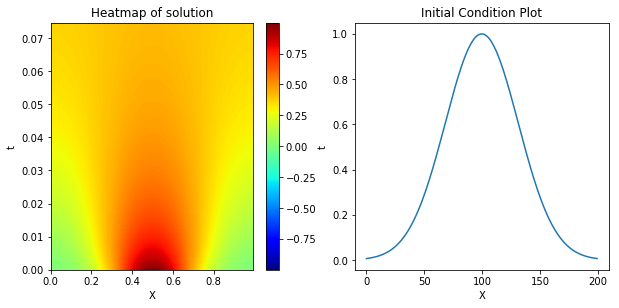

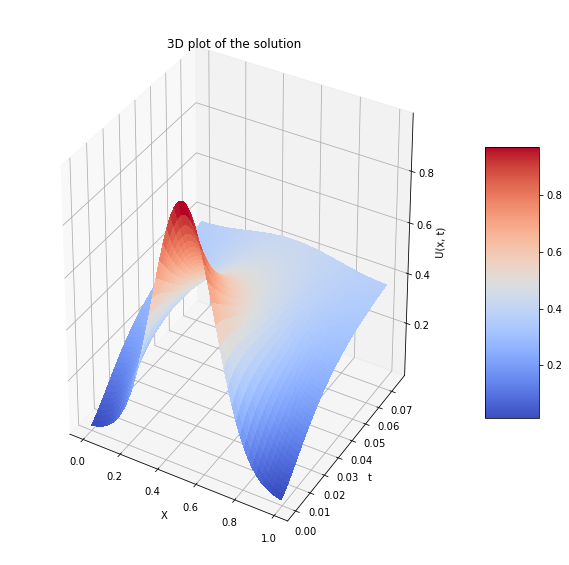

In [145]:
# Optional variables for changing the names of graphs 1, 2 and 3 respectively
format1 = []
format2 = []
format3 = []

plot_data(x2, t_end, sol_arr, dx, dt, format1, format2, format3)

Defining the next set of functions for q2 and also one more general function for the remaining 3 quesitons. Since none of the remaining methods implement guesses we can now use time_fill to save the values of the next time step for q's 2-4.

cd is quite similar to cd2 from before, only slight changes as it calculates the first derivative only.

In [146]:
def time_fill(array, index, t, time_func):
    """Computes the solution at time t using the given function time_func
    and saves it in the global variable sol_arr"""
    sol_arr[tuple([t] + index)] = time_func(array, index, t)
    return

def cd(array, index, boundary):
    """Finds the first derivative w.r.t. position using centered differences"""
    diff = 0
    for i in range (len(index)):
        num = 0
        if not boundary:
            for j in [-1, 2]:
                index[i] += j
                num += array[tuple(index)]*(j/abs(j))
            index[i] -= 1
        else:
            temp = index[i]
            for j in [1, -2]:
                index[i] = j
                num += array[tuple(index)]*(j/abs(j))
            index[i] = temp
        diff += num/(2*steps[i])
    return diff 

def forward_euler(array, index, t):
    """Calulates the value at the next timestep using a forward euler method"""
    RHS = (sol_arr[tuple([t-1] + index)] + 
        steps[-1]*deriv_arr[tuple([t-1] + index)])
    return RHS

def init_cond(x):
    return np.sin(2*np.pi*x)

There are no more comments beyond this point since the variables and solving methods are almost identical to before. 

Q.2

In the next computation of the solution to the advection equation we get initally what seems like a bad solution but a solution nonetheless. As we change our steps however the solution only gets worse, blowing up and returning values sometimes on the order of 1e300. 

It blows up so fast that the 3d graphs are almost flat apart from the end due to the values there being so much larger. Eventually it gets so large overflow errors occur and the plots become meaningless. Thus we can clearly see that this method is unstable.

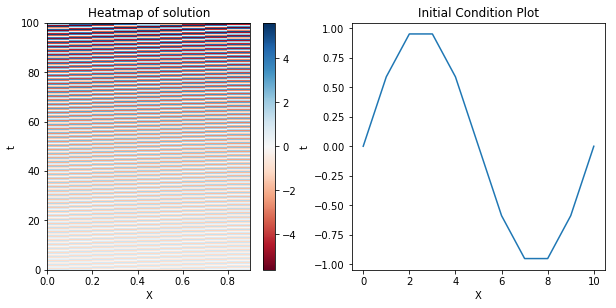

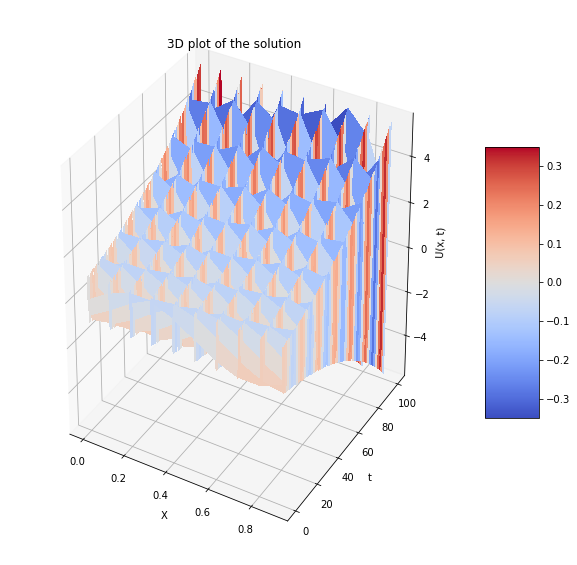

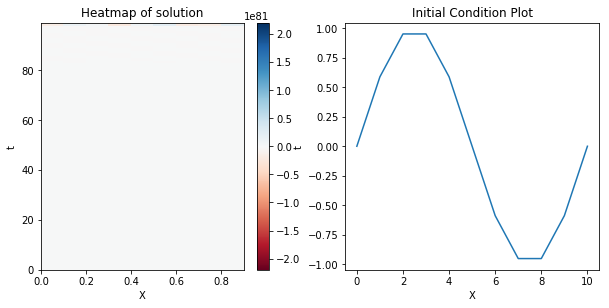

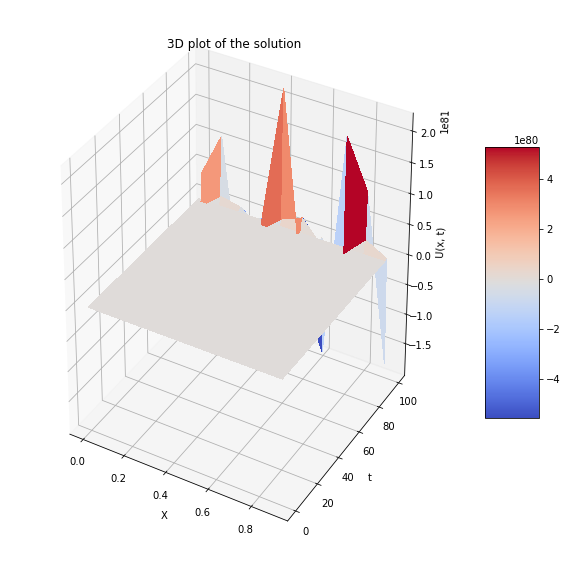

C:\Users\Zein\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Zein\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Zein\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
C:\Users\Zein\Anaconda3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


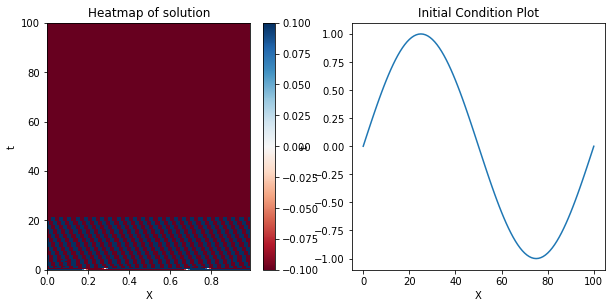

C:\Users\Zein\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:160: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


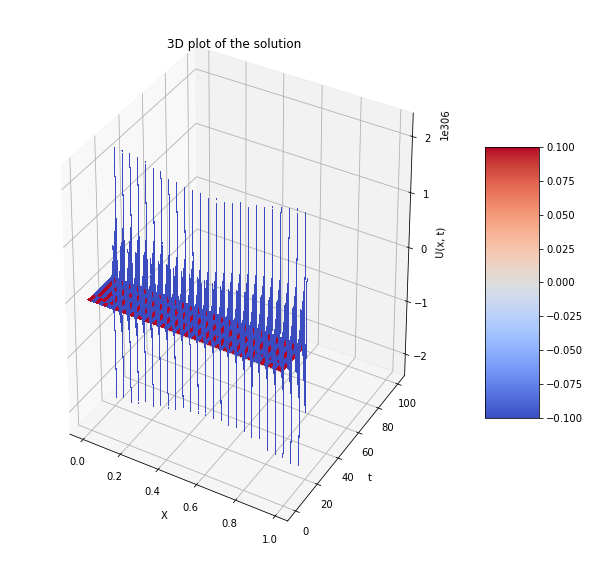

C:\Users\Zein\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


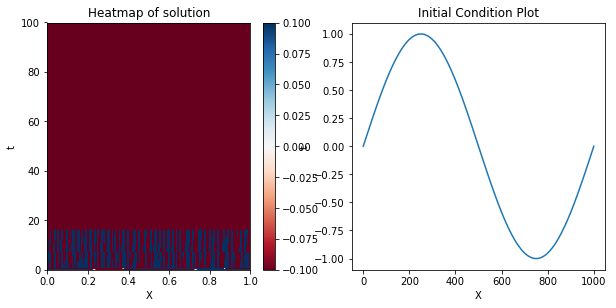

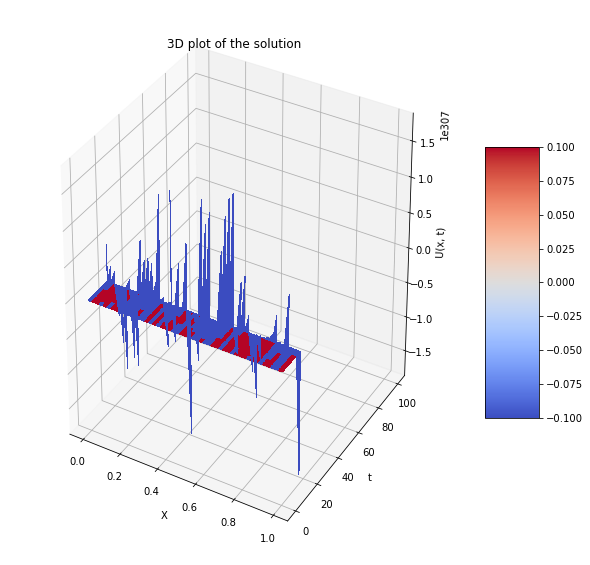

In [147]:
t_end = 100
xsteps = np.array([0.1, 0.1, 0.01, 0.001])
tsteps = np.array([0.001, 1.0, 0.01, 0.1])

for step_size in range(4):
    
    dx = xsteps[step_size]
    dt = tsteps[step_size]
    
    x_points = int((x2)/dx) + 1
    t_points = int((t_end)/dt) + 1
    
    steps = [dx, dt]

    sol_arr = np.zeros((t_points, x_points))
    deriv_arr = np.zeros((t_points, x_points))

    for i in range(x_points):
        sol_arr[0, i] = init_cond(i*dx)

    t = 0

    for i in range(t_points-1):
        array_iter(sol_arr[t], fill_deriv, funcpars=[t, cd])
        t += 1
        array_iter(sol_arr[t], time_fill, funcpars=[t, forward_euler])
        
        
    format1 = []
    format2 = []
    format3 = []

    plot_data(x2, t_end, sol_arr, dx, dt, format1, format2, format3, 'RdBu')

In [148]:
def init_cond(x):
    return np.sin(2*np.pi*x)

def leap_frog(array, index, t):
    """Finds the next guess for element at index using leap frog"""
    
    RHS = (sol_arr[tuple([t-2] + index)] + 
            2*steps[-1]*deriv_arr[tuple([t-1] + index)])
    return RHS

Q.3

Unable to implement a filter I simply selected step values carefully so that the code would run without consuming all of the computers memory. 

As we can see from the heatmaps particularly, as the CFL conditon improves (CFL < 1 is the condition for stability) the heatmap becomes increasingly more distinct in its pattern. The final two heatmaps might require a zoom to see the difference but the final one does look sharper. 

Due to the large timescale this solution is plotted on the 3d graphs look kinda crazy but I left them in because they'reinteresting to look at and compare with Q.4

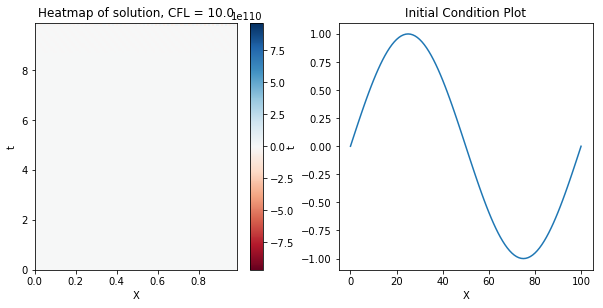

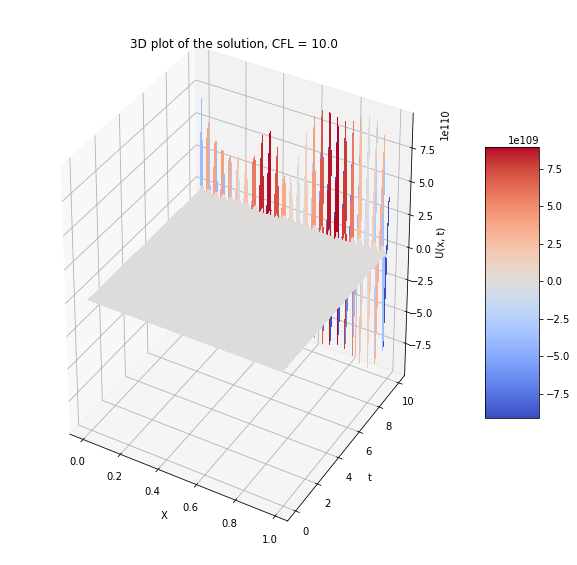

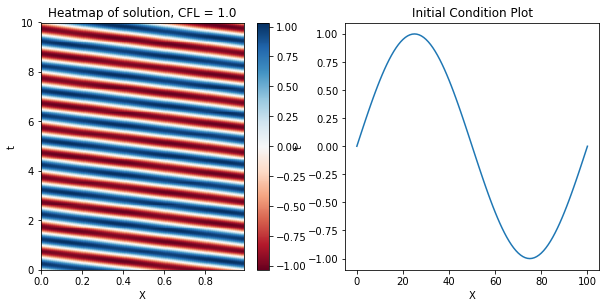

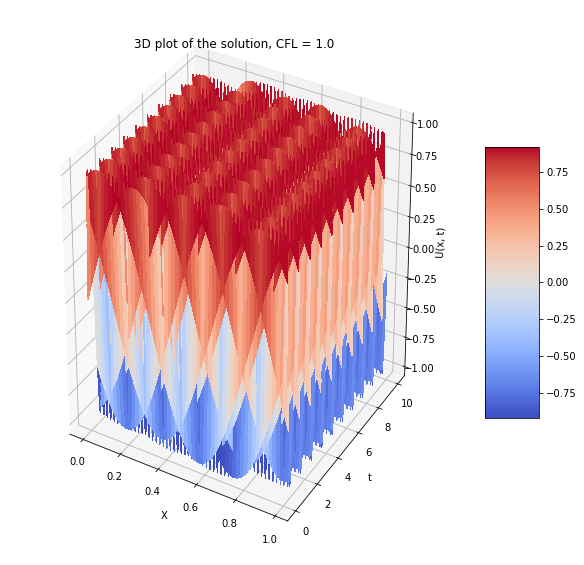

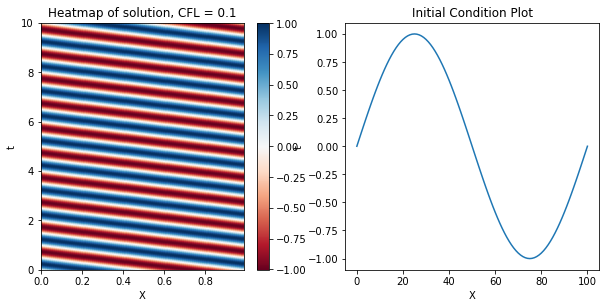

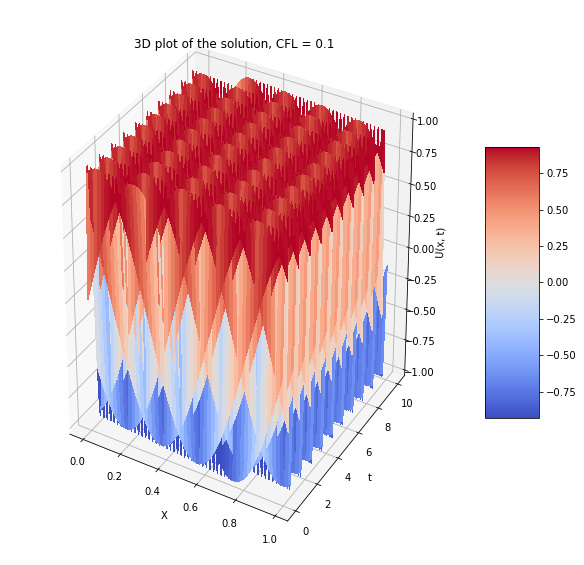

In [149]:
t_end = 10
xsteps = np.array([0.01, 0.01, 0.01])
tsteps = np.array([0.1, 0.01, 0.001])

for step_size in range(len(xsteps)):
    dx = xsteps[step_size]
    dt = tsteps[step_size]
    
    x_points = int((x2)/dx) + 1
    t_points = int((t_end)/dt) + 1
    
    steps = [dx, dt]

    sol_arr = np.zeros((t_points, x_points))
    deriv_arr = np.zeros((t_points, x_points))

    for i in range(x_points):
        sol_arr[0, i] = init_cond(i*dx)
        sol_arr[1, i] = init_cond(i*dx)
        
    t = 1
    for i in range(t_points-3):
        array_iter(sol_arr[t], fill_deriv, funcpars=[t, cd])
        t += 1
        array_iter(sol_arr[t], time_fill, funcpars=[t, leap_frog])

    format1 = ['Heatmap of solution, CFL = {}'.format(dt/dx), 'X', 't']
    format2 = ["Initial Condition Plot", 'X', 't'] 
    format3 = ["3D plot of the solution, CFL = {}".format(dt/dx), 'X', 
               't','U(x, t)']

    plot_data(x2, t_end, sol_arr, dx, dt, format1, format2, format3, 'RdBu')

Q.4
One point of note about the code is that the timesteps equal the space steps. This is done so that the cfl condition is always just fulfilled .

We observe a clear convergence in this computation of the advection equation as dx decreases. This time it is much clearer by viewing the 3d plots of the solution at each space step.

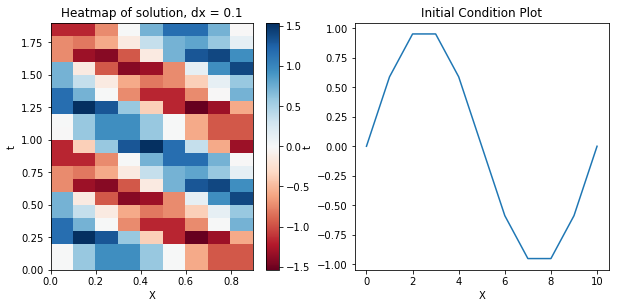

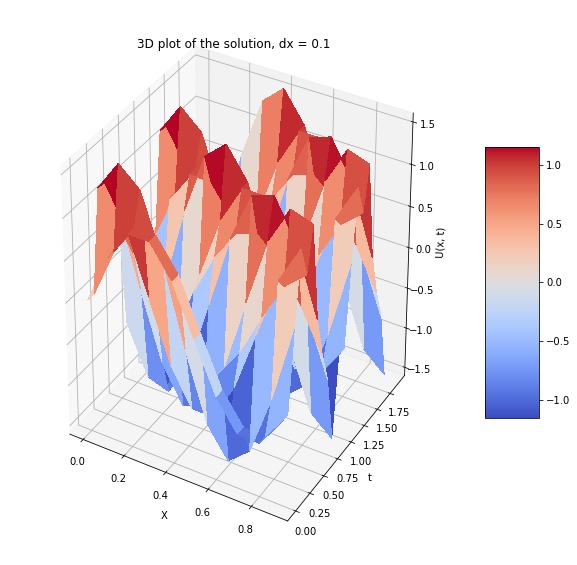

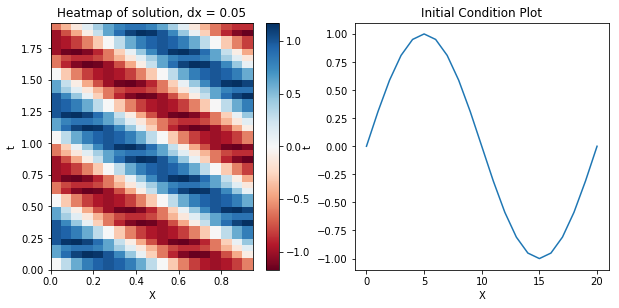

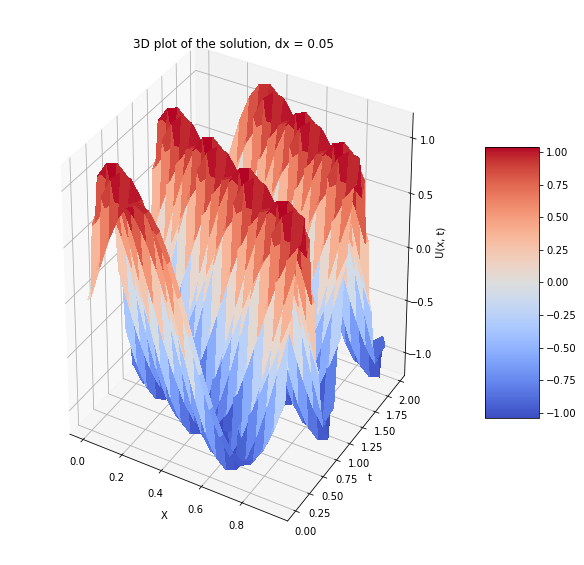

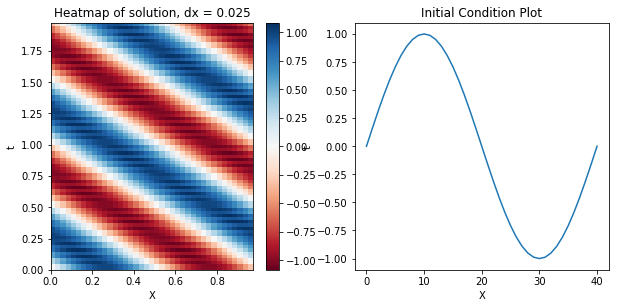

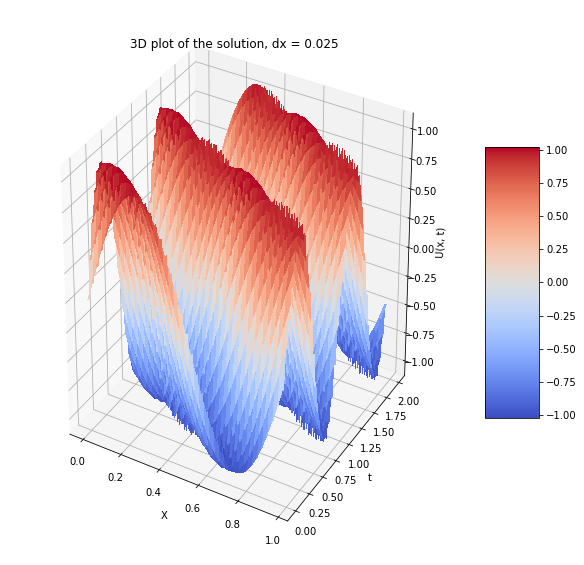

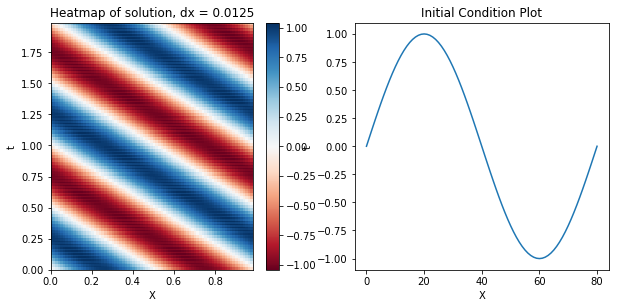

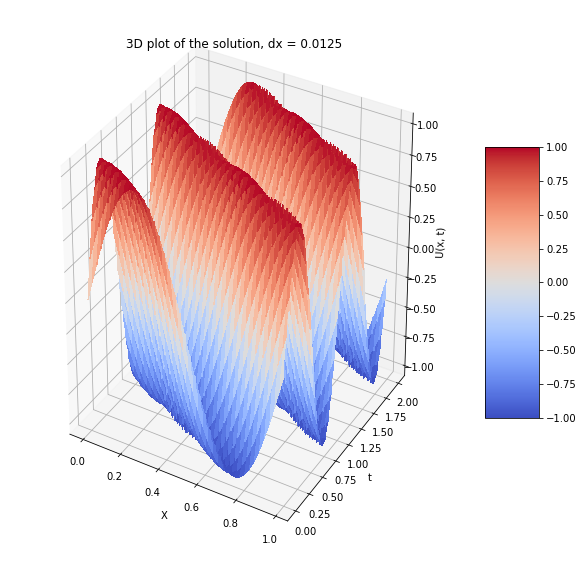

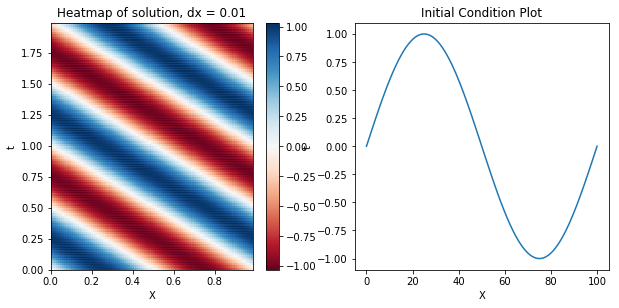

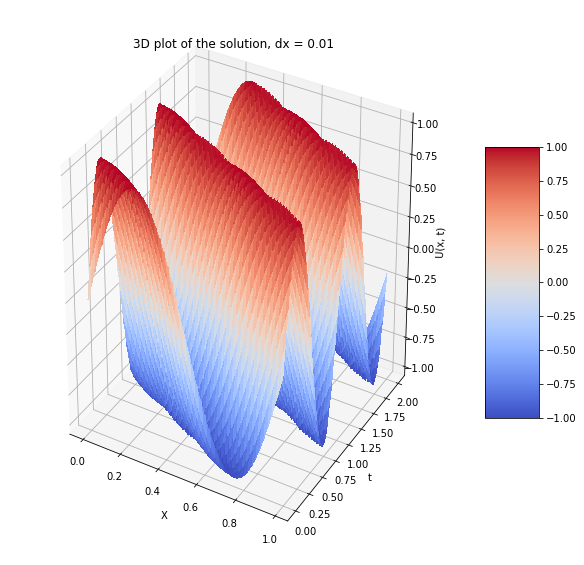

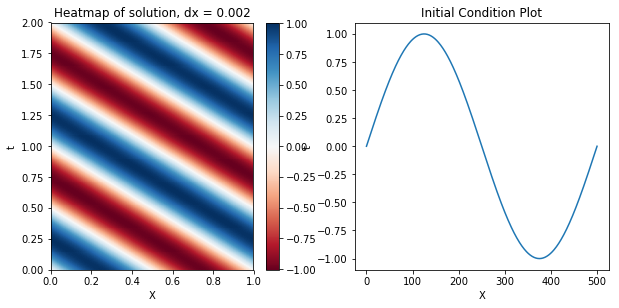

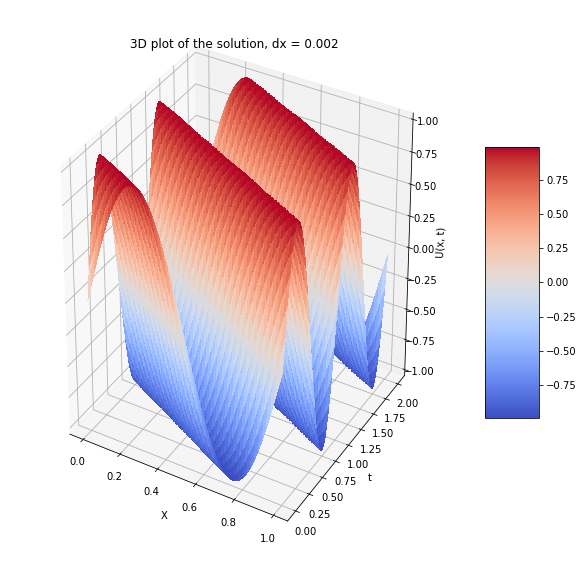

In [150]:
t_end = 2
xsteps = np.array([0.1, 0.05, 0.025, 0.0125, 0.01, 0.002])
tsteps = xsteps

all_solutions = []
for step_size in range(len(xsteps)):
    dx = xsteps[step_size]
    dt = tsteps[step_size]
    
    x_points = int((x2)/dx) + 1
    t_points = int((t_end)/dt) + 1
    
    steps = [dx, dt]

    sol_arr = np.zeros((t_points, x_points))
    deriv_arr = np.zeros((t_points, x_points))

    for i in range(x_points):
        sol_arr[0, i] = init_cond(i*dx)
        sol_arr[1, i] = init_cond(i*dx)
        
    t = 1
    for i in range(t_points-3):
        array_iter(sol_arr[t], fill_deriv, funcpars=[t, cd])
        t += 1
        array_iter(sol_arr[t], time_fill, funcpars=[t, leap_frog])

    format1 = ['Heatmap of solution, dx = {}'.format(dx), 'X', 't']
    format2 = ["Initial Condition Plot", 'X', 't'] 
    format3 = ["3D plot of the solution, dx = {}".format(dx), 'X', 
               't','U(x, t)']

    plot_data(x2, t_end, sol_arr, dx, dt, format1, format2, format3, 'RdBu')
    
    all_solutions += [sol_arr]

Q.4

The code below calculates the numerical error for question 4. Essentially it takes the difference at common values of x and t and takes the mean of these differences.

What was found was that the error was decreasing and converging however it starts to hover around 0.34 while the plots above show convergence to a certain shape. On the final time step the error is actually slightly increased, however I believe this is due to the final timestep making the solution much more accurate as the final heatmap is much smoother and devoid of criss cross pattern present in the previous heat maps.

In [151]:
# all_solutions contains the 6 solution arrays from above.
# Since each consectuive array has twice as many values as the last
# we half it first before taking the differences

for solution in range(len(all_solutions)-3):
    shape = all_solutions[solution].shape
    halved_array = np.zeros(all_solutions[solution].shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            halved_array[i, j] = all_solutions[solution+1][i*2, j]
    difference = np.absolute(halved_array) - np.absolute(all_solutions[solution])
    difference = np.absolute(difference)
    print("The error on the dx = {} timestep is".format(xsteps[solution]), 
          np.round(np.mean(difference), 5))
    
shape = all_solutions[-2].shape
halved_array = np.zeros(all_solutions[-2].shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        halved_array[i, j] = all_solutions[-1][i*2, j]
difference = np.absolute(halved_array) - np.absolute(all_solutions[-2])
difference = np.absolute(difference)
print("The error on the dx = 0.01 timestep is", np.round(np.mean(difference), 5))

The error on the dx = 0.1 timestep is 0.42123
The error on the dx = 0.05 timestep is 0.35179
The error on the dx = 0.025 timestep is 0.34251
The error on the dx = 0.01 timestep is 0.34819
